# Phosphorus-based anodes for potassium-ion batteries: insights from computational structure prediction

## Summary


In this project I've done some structure prediction on the K-P phase diagram (as part of the ternary K-Sn-P). First I took the experimental phases from the ISCD (via our copy of the OQMD) and relaxed them with reasonably low accuracy (PBE, 300 eV, 0.07 1/Å kpoint spacing). Then I took all known [I]-[VI] binary compounds and "swapped" them to K-P using matador, relaxing those too. Then I ran some AIRSS (with pyairss), followed by evolutionary searches (with ilustrado) before "polishing" all structures that were found to be less than 100 meV/atom away from the rough convex hull. These calculations were ran with CASTEP OTF pseudopotentials, improved kpoints spacing (0.03 1/Å) and low force tolerances (0.01 -> 0.0001 eV/Å). The results are shown in the plots below.

Under PBE, the ICSD phase of K<sub>3</sub>P is found to be unstable, but lies very close to the hull. Likewise the often observed electrochemical endpoint K<sub>4</sub>P<sub>3</sub> is close to being stable, but is knocked off the hull by a swap phase of K<sub>5</sub>P<sub>4</sub> that no-one else has reported. We find some new phases with low K content, e.g. K<sub>3</sub>P<sub>11</sub> and K<sub>3</sub>P<sub>7</sub>, though they are less interesting in a battery context. Importantly, we predict several new phases that are at the same energy as the ICSD K<sub>3</sub>P, which may explain why no-one has seen it.

Since our predicted theoretical capacity of the battery depends entirely on the stable phases, I set out to try to include the fact that K<sub>3</sub>P is so close to the hull. In doing so, I ended up implementing the Bayesian Error Estimate Functional (BEEF) in CASTEP (not merged into the main release yet), which provides a way to assess the uncertainty in standard DFT calculations by creating an ensemble of randomly perturbed xc-functionals that are evaluated non-self-consistently on the PBE ground state geometries. The PBE-BEEF hull and the more advanced meta-GGA mBEEF-vdW hull (computed with GPAW on the PBE structures) are found below, and show the probability of different phases forming across the hulls generated with the ensemble of functionals.

Just recently I've also rerun the calculations with the rSCAN functional in the development version of CASTEP. This meta-GGA functional has been shown to perform better than PBE for formation energies at approximately double the computational cost. Phonon calculations across the entire hull have proved slightly tricky due to various reasons, but are nearly completed for the new phases. The aim was to make a finite temperature convex hull, but the instability of phosphorus under PBE makes it difficult. The ICSD K<sub>3</sub>P phase is shown to be dynamically unstable, unlike the new phases we are predicting.

### BEEF papers:

1. Mortensen, J. J.; Kaasbjerg, K.; Frederiksen, S. L.; Nørskov, J. K.; Sethna, J. P.; Jacobsen, K. W. Bayesian Error Estimation in Density-Functional Theory. Physical Review Letters 2005, 95 (21). https://doi.org/10.1103/PhysRevLett.95.216401.  
2. Lundgaard, K. T.; Wellendorff, J.; Voss, J.; Jacobsen, K. W.; Bligaard, T. MBEEF-VdW: Robust Fitting of Error Estimation Density Functionals. Phys. Rev. B 2016, 93 (23), 235162. https://doi.org/10.1103/PhysRevB.93.235162.

### SCAN papers

3. Bartók, A. P.; Yates, J. R. Regularized SCAN Functional. J. Chem. Phys. 2019, 150 (16), 161101. https://doi.org/10/gf8j2p.  
4. Sun, J.; Remsing, R. C.; Zhang, Y.; Sun, Z.; Ruzsinszky, A.; Peng, H.; Yang, Z.; Paul, A.; Waghmare, U.; Wu, X.; et al. Accurate First-Principles Structures and Energies of Diversely Bonded Systems from an Efficient Density Functional. Nature Chemistry 2016, 8 (9), 831–836. https://doi.org/10/f85xq7.


### Useful battery papers on K-P:

5. Wu, Y.; Huang, H.-B.; Feng, Y.; Wu, Z.-S.; Yu, Y. The Promise and Challenge of Phosphorus-Based Composites as Anode Materials for Potassium-Ion Batteries. Advanced Materials 0 (0), 1901414. https://doi.org/10/gf7hxn.  
6. Zhang, W.; Pang, W. K.; Sencadas, V.; Guo, Z. Understanding High-Energy-Density Sn4P3Anodes for Potassium-Ion Batteries. Joule 2018, 1–14. https://doi.org/10/gf2547.  
7. Kubota, K.; Dahbi, M.; Hosaka, T.; Kumakura, S.; Komaba, S. Towards K-Ion and Na-Ion Batteries as “Beyond Li-Ion.” The Chemical Record 2018, 1–22. https://doi.org/10/gf255b.  
8. Kim, H.; Kim, J. C.; Bianchini, M.; Seo, D.-H.; Rodriguez-Garcia, J.; Ceder, G. Recent Progress and Perspective in Electrode Materials for K-Ion Batteries. Advanced Energy Materials 2018, 8 (9), 1702384. https://doi.org/10/gdf3xg.  
9. Sultana, I.; Rahman, M. M.; Ramireddy, T.; Chen, Y.; Glushenkov, A. M. High Capacity Potassium-Ion Battery Anodes Based on Black Phosphorus. J. Mater. Chem. A 2017. https://doi.org/10/gf25z2.  
10. Zhang, W.; Mao, J.; Li, S.; Chen, Z.; Guo, Z. Phosphorus-Based Alloy Materials for Advanced Potassium-Ion Battery Anode. Journal of the American Chemical Society 2017, 139 (9), 3316–3319. https://doi.org/10/f9r2p9.

In [1]:
import tqdm
import glob
import pickle
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict
%matplotlib inline

## Stability & voltage curves for PBE vs rSCAN

#### PBE

Loading settings from /u/fs1/me388/.matadorrc
1858 results found for query in me388_KSnP.
Creating hull from structures in query results.

Finding the best calculation set for hull...
     masquerade pen     : matched 1830 structures.	-> PBE, 650.0 eV, 0.01 eV/A, 0.0287 1/A
Matched at least 2/3 of total number, composing hull...
Composing hull from set containing masquerade pen
────────────────────────────────────────────────────────────
Scanning for suitable K chemical potential...
Using prophesy request as chem pot for K
────────────────────────────────────────────────────────────
Scanning for suitable P chemical potential...
Using underworld cloth as chem pot for P
────────────────────────────────────────────────────────────
9 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ID              !?!  Pressure  Volume/fu  Hull dist.   Space

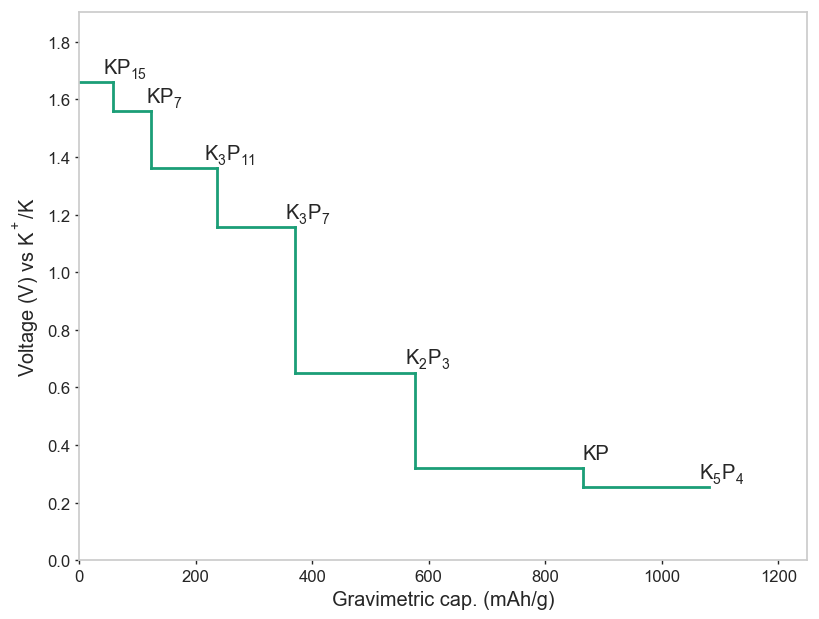

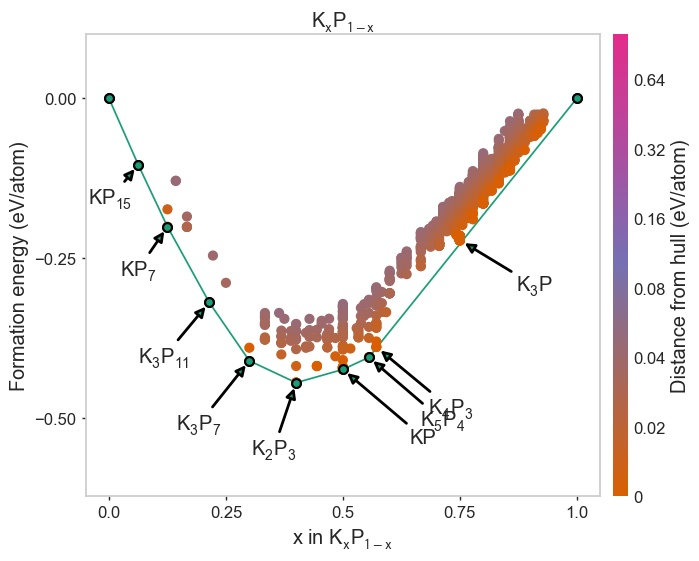

In [2]:
query = DBQuery(composition='KP', geom_force_tol=0.01, db='me388_KSnP', subcmd='voltage', label_cutoff=8e-3)
pbe_hull = QueryConvexHull(query, subcmd='voltage')

#### rSCAN

Loading settings from /u/fs1/me388/.matadorrc
28 results found for query in me388_KSnP.
Creating hull from structures in query results.

Finding the best calculation set for hull...
    excruciate plant    : matched 28 structures.	-> RSCAN, 650.0 eV, 0.01 eV/A, 0.0277 1/A
Matched all structures...
Composing hull from set containing excruciate plant
────────────────────────────────────────────────────────────
Scanning for suitable K chemical potential...
Using bier maid as chem pot for K
────────────────────────────────────────────────────────────
Scanning for suitable P chemical potential...
Using relevant robin as chem pot for P
────────────────────────────────────────────────────────────
10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ID              !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  

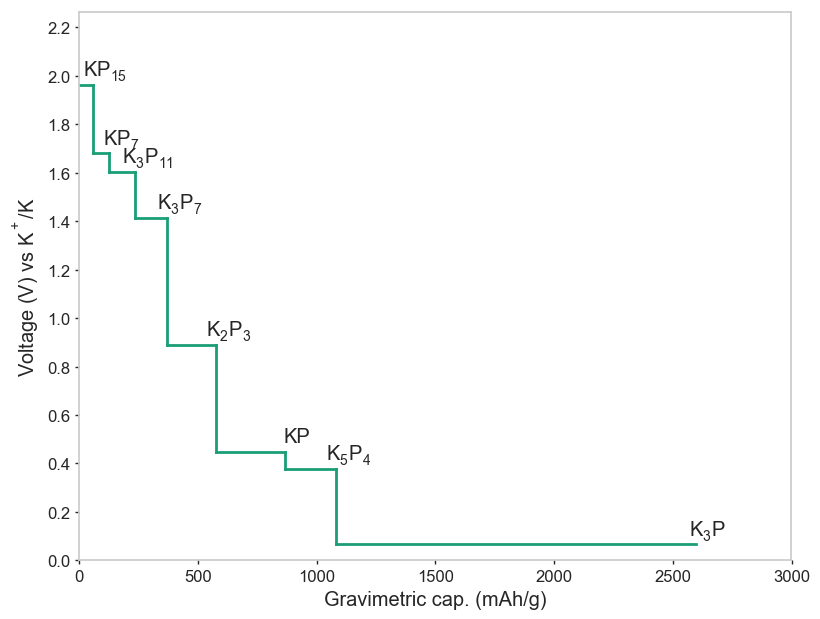

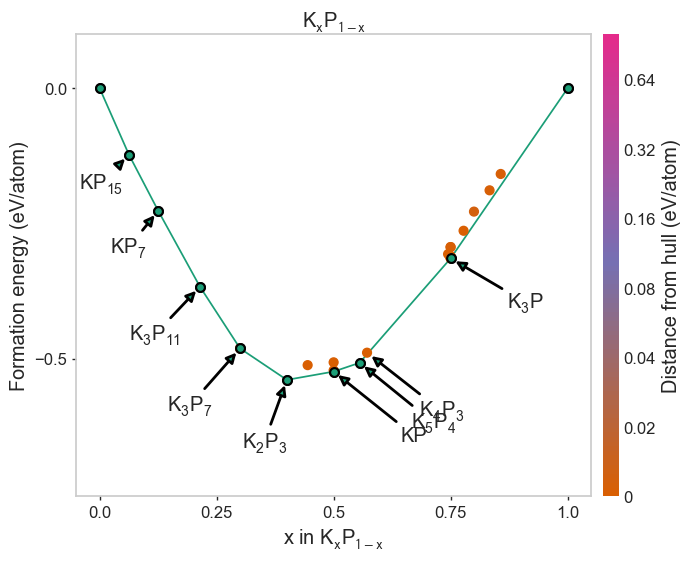

In [3]:
query = DBQuery(composition='KP', db='me388_KSnP', subcmd='voltage', xc_functional='RSCAN', label_cutoff=8e-3)
scan_hull = QueryConvexHull(query, subcmd='voltage')

#### Materials project PBE results

Generating fake chempots...
──────────────────────────────────────────────────
Custom chempots:K   = 0.0 eV/fu, P   = 0.0 eV/fu, 
──────────────────────────────────────────────────
7 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* mp-569857                                       0.00        0.2          0.0    Fddd          K2P3         4     AIRSS  
* mp-7441                                         0.00        0.1         -0.0 P2_12_12_1        KP          8     AIRSS  
* mp-28424                                  

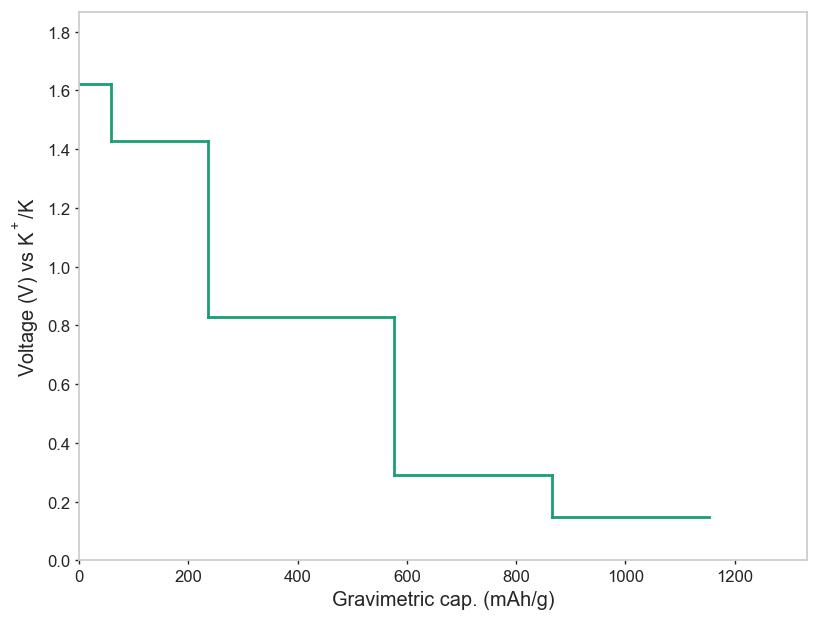

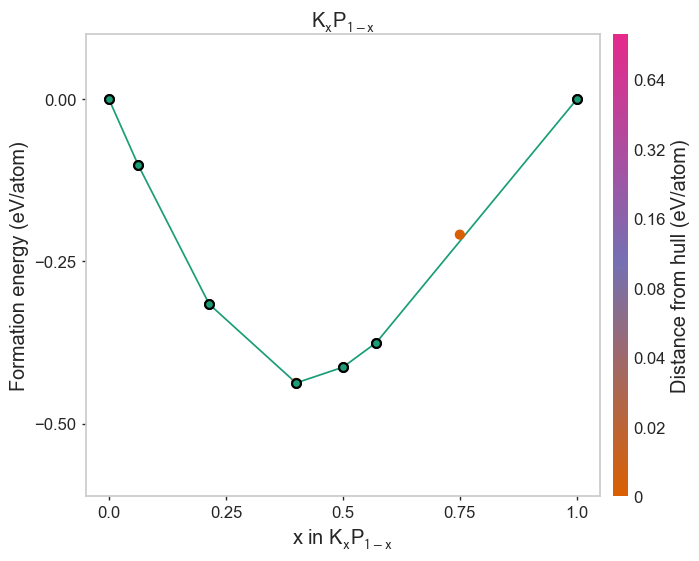

In [4]:
# grab some materials project data too
import pickle
with open('/home/users/me388/proj/aalto/notebooks/mp_KP.pickle', 'rb') as f:
    mp_cursor = pickle.load(f)
# temp fix for outdated data
for doc in mp_cursor:
    doc['cell_volume'] = 1
mp_hull = QueryConvexHull(cursor=mp_cursor, species='KP', chempots=[0,0], subcmd='voltage')

#### OQMD PBE results, with FERE corrections

Loading settings from /u/fs1/me388/.matadorrc
20 results found for query in oqmd_1.2.
Creating hull from structures in query results.

Finding the best calculation set for hull...
     centenary care     : matched 20 structures.	-> PBE, 520.0 eV, xxx eV/A, 0.018 1/A
Matched all structures...
Composing hull from set containing centenary care
────────────────────────────────────────────────────────────
Scanning for suitable K chemical potential...
Using aroma jail as chem pot for K
────────────────────────────────────────────────────────────
Scanning for suitable P chemical potential...
Using ground transport as chem pot for P
────────────────────────────────────────────────────────────
6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ID              !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
     

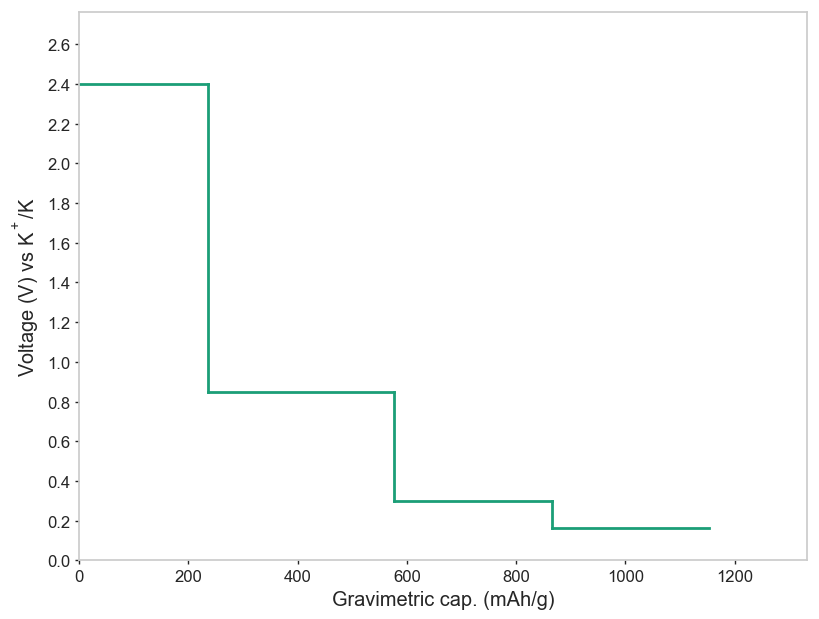

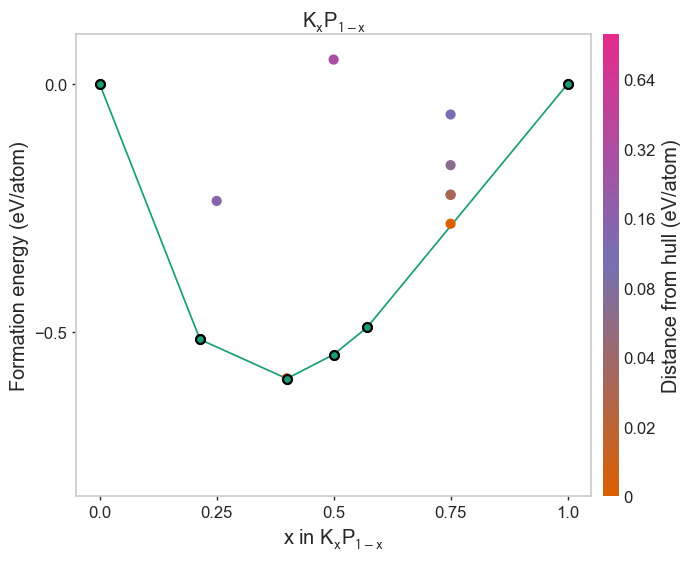

In [5]:
query = DBQuery(composition='KP', db='oqmd_1.2', subcmd='voltage')
oqmd_hull = QueryConvexHull(query, subcmd='voltage', species='KP')

#### Comparison of voltages & hulls

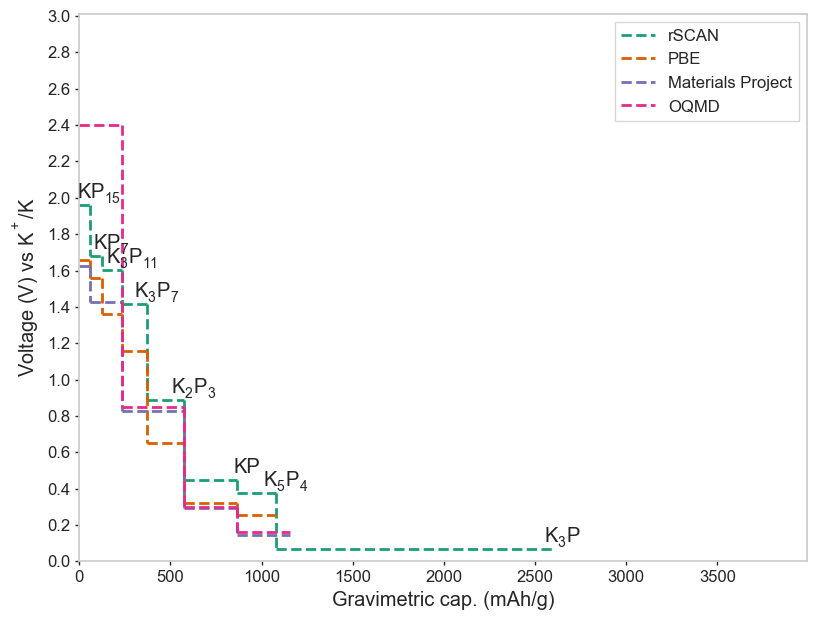

In [6]:
from matador.plotting.battery_plotting import plot_voltage_curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pbe_hull.args['label_cutoff'] = None
plot_voltage_curve(scan_hull, ax=ax, show=False, curve_label='rSCAN', ls='--', c=scan_hull.colours[0])
plot_voltage_curve(pbe_hull, ax=ax, show=False, curve_label='PBE', ls='--', c=scan_hull.colours[1])
plot_voltage_curve(mp_hull, ax=ax, show=False, curve_label='Materials Project', ls='--', c=scan_hull.colours[2])
plot_voltage_curve(oqmd_hull, ax=ax, show=False, curve_label='OQMD', ls='--', c=scan_hull.colours[3])
_ = ax.legend()

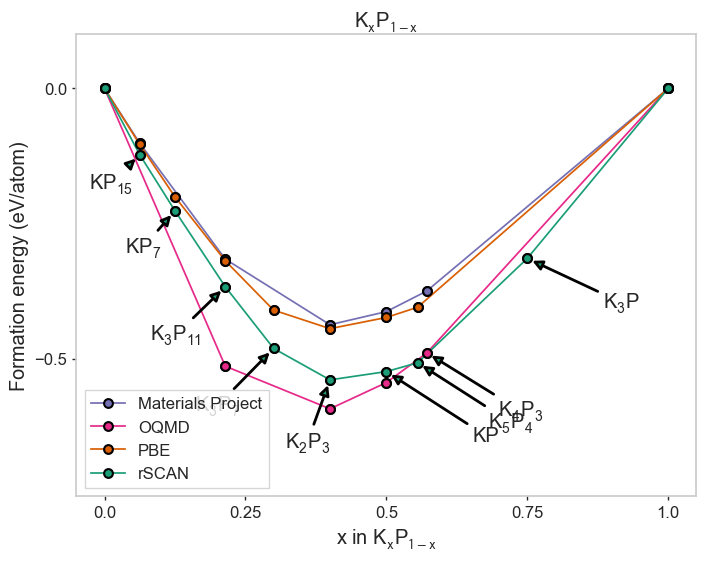

In [7]:
from matador.plotting.hull_plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pbe_hull.args['label_cutoff'] = None
# hack colours for now
pbe_hull.colours = scan_hull.colours[1:]
mp_hull.colours = scan_hull.colours[2:]
oqmd_hull.colours = scan_hull.colours[3:]
plot_2d_hull(mp_hull, ax=ax, show=False, plot_points=False, hull_label='Materials Project')
plot_2d_hull(oqmd_hull, ax=ax, show=False, plot_points=False, hull_label='OQMD')
plot_2d_hull(pbe_hull, ax=ax, show=False, plot_points=False, hull_label='PBE')
plot_2d_hull(scan_hull, ax=ax, show=False, plot_points=False, hull_label='rSCAN')
_ = ax.legend()

## BEEF hulls

#### PBE-based BEEF in CASTEP

In [8]:
fname = 'pickled_beef.pickle'
import pickle
import os
if os.path.isfile(fname):
    print('Loading pickled cursor.')
    with open(fname, 'rb') as f:
        beef_cursor = pickle.load(f)
else:
    files = glob.glob('/u/fs1/me388/proj/KPX/K+P/KP-650-0.02-1.75-1.75-PBE-OTF-0.01-BEEF/completed/*.castep')
    beef_cursor = []
    for f in tqdm.tqdm(files):
        doc, s = castep2dict(f, db=False, verbosity=10)
        if not s:
            raise s
        beef_cursor.append(doc)
    with open(fname, 'wb') as f:
        pickle.dump(beef_cursor, f)

Loading pickled cursor.


In [9]:
beef_hull = EnsembleHull(beef_cursor, '_beef', 'total_energy_per_atom', num_samples=500, species='KP')

10 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-Na-Collo                                      0.02       73.3          0.0    Im-3m           K          1     SWAPS  
* KP-yzcni8                                      -0.00      145.5          0.0   Pmn2_1          K3P         4     AIRSS  
* KP-NaP-CollCode56530                            0.00      267.8          0.0    C2/m          K5P4         1     SWAPS  
* KP-OQMD_2818-CollCode14010                      0.00       57.4          0.0 P2_12_12_1        KP  

  0%|          | 0/500 [00:00<?, ?it/s]

Found 5000 entries under data key: _beef.
Using 500 out of 5000 possible phase diagrams.


100%|██████████| 500/500 [00:23<00:00, 20.77it/s]


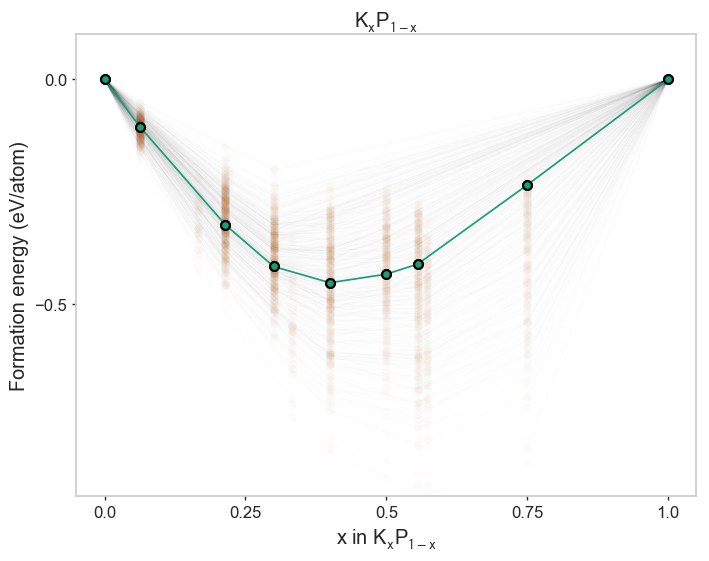

In [10]:
beef_hull.plot_hull(plot_points=False)

defaultdict(<class 'int'>, {'K': 500, 'K3P': 210, 'K4P3': 166, 'K5P4': 338, 'KP': 308, 'K2P3': 429, 'K3P7': 446, 'K3P11': 485, 'KP15': 337, 'P': 500, 'KP2': 63, 'KP5': 48, 'K2P7': 8, 'K4P5': 2, 'K7P2': 2})


<BarContainer object of 15 artists>

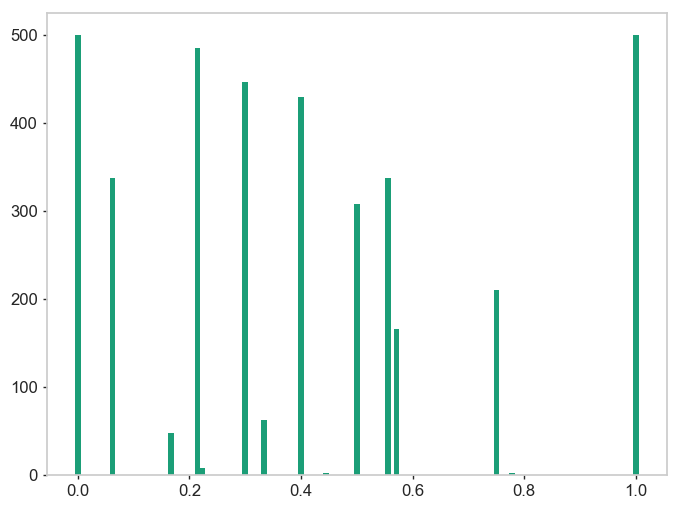

In [12]:
from matador.utils.chem_utils import get_stoich_from_formula
from matador.utils.chem_utils import get_concentration
stability_hist = beef_hull.generate_stability_statistics(group_by='formula')
print(stability_hist)
plt.bar([get_concentration(get_stoich_from_formula(key), ['K', 'P'])[0] for key in stability_hist], 
        [stability_hist[key] for key in stability_hist], 0.01)

#### GPAW mBEEF-vdW

In [13]:
gpaw_files = glob.glob('/u/fs1/me388/proj/KPX/K+P/*GPAW*/beef_test/completed/*.beef.out')
import numpy as np
from matador.utils.chem_utils import get_stoich
gpaw_cursor = []
for f in tqdm.tqdm(gpaw_files):
    doc = {}
    doc['source'] = [f.split('/')[-1].replace('.beef.out', '.res')]
    doc['_beef'] = {}
    doc['_beef']['total_energy'] = np.loadtxt(f)
    with open(f.replace('beef.out', 'gpaw.out'), 'r') as _f:
        flines = _f.readlines()
    for ind, line in enumerate(flines):
        if 'Free energy' in line:
            doc['free_energy'] = float(flines[ind].split()[-1])
            doc['total_energy'] = float(flines[ind+1].split()[-1])
        if 'Number of atoms' in line:
            doc['num_atoms'] = int(line.split()[-1])
        if 'Positions:' in line:
            doc['atom_types'] = []
            i = ind + 1
            while flines[i].strip():
                doc['atom_types'].append(flines[i].split()[1])
                i += 1
    doc['stoichiometry'] = get_stoich(doc['atom_types'])
    doc['num_fu'] = len(doc['atom_types']) / sum([atom[1] for atom in doc['stoichiometry']])
    doc['free_energy_per_atom'] = doc['free_energy'] / doc['num_atoms']
    doc['total_energy_per_atom'] = doc['total_energy'] / doc['num_atoms']
    doc['_beef']['total_energy_per_atom'] = (doc['_beef']['total_energy'] / doc['num_atoms']).tolist()
    doc['_beef']['total_energy'] = doc['_beef']['total_energy'].tolist()
    gpaw_cursor.append(doc)

100%|██████████| 1137/1137 [00:19<00:00, 59.96it/s]


In [14]:
mbeef_hull = EnsembleHull(gpaw_cursor, '_beef', 'total_energy_per_atom', species='KP', num_samples=2000)

  0%|          | 3/2000 [00:00<01:26, 23.22it/s]

9 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* K-Na-Collo                                    xxx       xxx              0.0     xxx            K          1     SWAPS  
* K4P3-OQMD_11858-CollCode64625                 xxx       xxx              0.0     xxx          K4P3         2      ICSD  
* KP-NaP-CollCode56530                          xxx       xxx              0.0     xxx          K5P4         1     SWAPS  
* K2P3-OQMD_6243-CollCode33259                  xxx       xxx              0.0     xxx          K2P3  

100%|██████████| 2000/2000 [01:26<00:00, 23.18it/s]


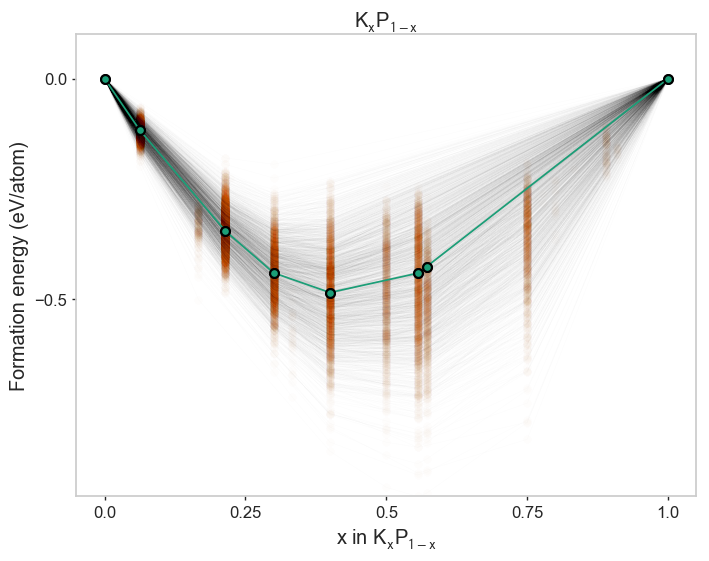

In [15]:
mbeef_hull.plot_hull(plot_points=False)

defaultdict(<class 'int'>, {'P': 2000, 'KP15': 1850, 'K3P11': 3710, 'K3P7': 1967, 'K2P3': 1981, 'K5P4': 1697, 'K4P3': 771, 'K3P': 961, 'K': 2000, 'KP': 861, 'KP5': 160, 'K8P': 78, 'K10P': 13, 'KP2': 28, 'K4P': 14, 'K5P': 2, 'K7P2': 2, 'K2P7': 1})


<BarContainer object of 18 artists>

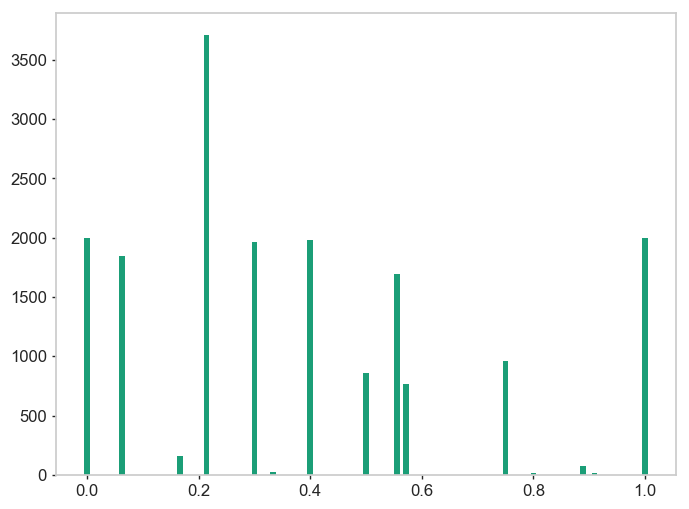

In [16]:
from matador.utils.chem_utils import get_stoich_from_formula
from matador.utils.chem_utils import get_concentration
stability_hist = mbeef_hull.generate_stability_statistics(group_by='formula')
print(stability_hist)
plt.bar([get_concentration(get_stoich_from_formula(key), ['K', 'P'])[0] for key in stability_hist], 
        [stability_hist[key] for key in stability_hist], 0.01)

### Messing with chemical potentials

#### Modify P chempot

Loading settings from /u/fs1/me388/.matadorrc
1858 results found for query in me388_KSnP.
Creating hull from structures in query results.

Finding the best calculation set for hull...
     masquerade pen     : matched 1830 structures.	-> PBE, 650.0 eV, 0.01 eV/A, 0.0287 1/A
Matched at least 2/3 of total number, composing hull...
Composing hull from set containing masquerade pen
────────────────────────────────────────────────────────────
Scanning for suitable K chemical potential...
Using prophesy request as chem pot for K
────────────────────────────────────────────────────────────
Scanning for suitable P chemical potential...
Using underworld cloth as chem pot for P
────────────────────────────────────────────────────────────
9 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ID              !?!  Pressure  Volume/fu  Hull dist.   Space

  2%|▏         | 2/100 [00:00<00:06, 14.50it/s]

Found 100 entries under data key: _variable_mu.


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


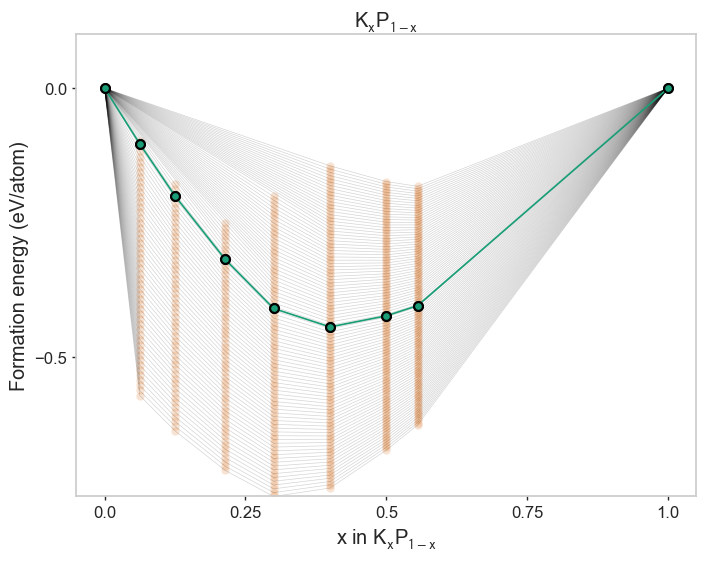

In [17]:
import numpy as np
query = DBQuery(composition='KP', geom_force_tol=0.01, db='me388_KSnP', subcmd='hull', no_plot=True)
hull = QueryConvexHull(query)
new_cursor = hull.cursor
space = np.linspace(-0.5, 0.5, 100)
for doc in new_cursor:
    doc['_variable_mu'] = {}
    if doc['stoichiometry'] == [['P', 1]]:
        doc['_variable_mu']['enthalpy_per_atom'] = (space + doc['enthalpy_per_atom']).tolist()
    else:
        doc['_variable_mu']['enthalpy_per_atom'] = (np.ones_like(space) * doc['enthalpy_per_atom']).tolist()

mu_hull = EnsembleHull(new_cursor, '_variable_mu', species='KP')
mu_hull.plot_hull(plot_points=False, alpha_scale=0.06)

#### Varying K chemical potential

Loading settings from /u/fs1/me388/.matadorrc
1858 results found for query in me388_KSnP.
Creating hull from structures in query results.

Finding the best calculation set for hull...
     masquerade pen     : matched 1830 structures.	-> PBE, 650.0 eV, 0.01 eV/A, 0.0287 1/A
Matched at least 2/3 of total number, composing hull...
Composing hull from set containing masquerade pen
────────────────────────────────────────────────────────────
Scanning for suitable K chemical potential...
Using prophesy request as chem pot for K
────────────────────────────────────────────────────────────
Scanning for suitable P chemical potential...
Using underworld cloth as chem pot for P
────────────────────────────────────────────────────────────
9 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ID              !?!  Pressure  Volume/fu  Hull dist.   Space

  2%|▏         | 2/100 [00:00<00:06, 14.66it/s]

Found 100 entries under data key: _variable_mu.


100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


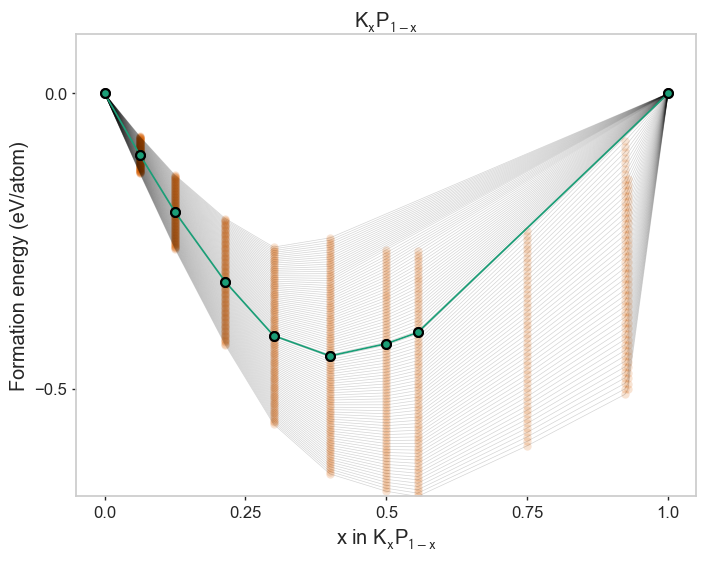

In [18]:
import numpy as np
query = DBQuery(composition='KP', geom_force_tol=0.01, db='me388_KSnP', subcmd='hull', no_plot=True)
hull = QueryConvexHull(query)
new_cursor = hull.cursor
space = np.linspace(-0.5, 0.5, 100)
for doc in new_cursor:
    doc['_variable_mu'] = {}
    if doc['stoichiometry'] == [['K', 1]]:
        doc['_variable_mu']['enthalpy_per_atom'] = (space + doc['enthalpy_per_atom']).tolist()
    else:
        doc['_variable_mu']['enthalpy_per_atom'] = (np.ones_like(space) * doc['enthalpy_per_atom']).tolist()

mu_hull = EnsembleHull(new_cursor, '_variable_mu', species='KP')
mu_hull.plot_hull(plot_points=False, alpha_scale=0.06)

In [26]:
from matador.crystal import Crystal
crystals = []
for doc in oqmd_hull.cursor:
    try:
        crystals.append(Crystal(doc))
    except:
        pass
pxrds = []
for crystal in tqdm.tqdm(crystals):
    pxrds.append(crystal.pxrd)

/u/fs1/me388/.local/conda/envs/dev2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


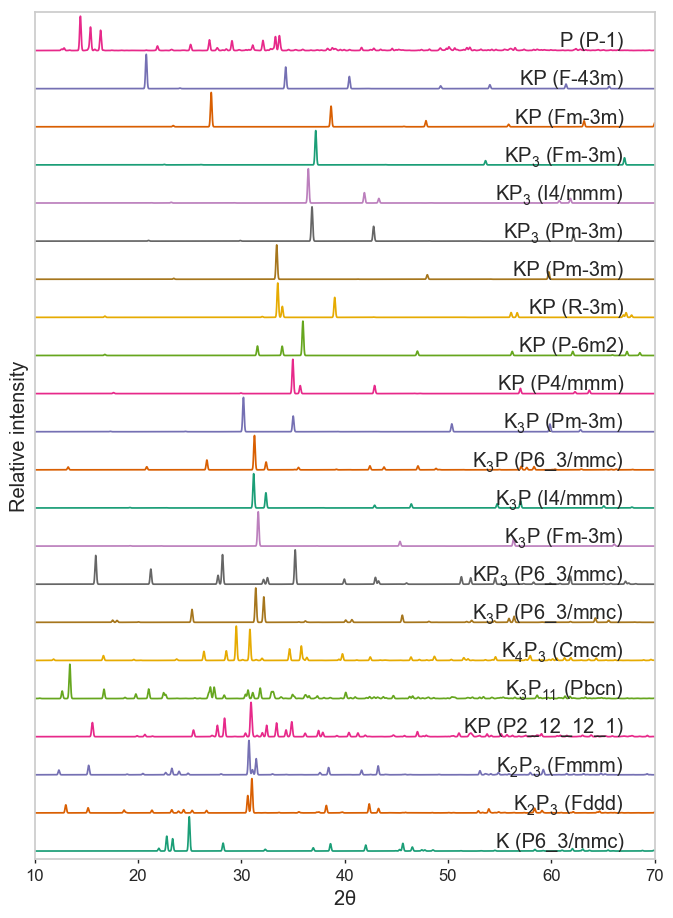

In [34]:
from matador.plotting import plot_pxrd
plot_pxrd(pxrds)